In [873]:
import sys
from typing import List, Dict, Tuple
from data_tools import task_map, row_operations
from utils import persistence as ps
from urllib3.response import HTTPResponse
from pandas import DataFrame, Series, read_csv, concat, Grouper, melt, merge_asof, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Process, cpu_count
from error_handling import errors
from scipy import stats
from geo_merger import geo_merge, EXT
from numpy import array, empty, float64, zeros_like, triu_indices_from, log, nan, inf, asarray
from time import sleep
from functools import reduce

In [874]:
import warnings
warnings.filterwarnings('ignore')

In [875]:
RGTRANSIT_BUCKET: str = 'rg-transit'
RGFARES_BUCKET: str = 'rg-tsfare'
RGGCABS_BUCKET: str = 'rg-gcabs'
RGYCABS_BUCKET: str = 'rg-ycabs'
RGTRAFFIC_BUCKET: str = 'rg-traffic'
REFBASE_BUCKET: str = 'ref-base'
GEOMERGED_PATH: str = 'geo-merged/'
PLOTS_BUCKET: str = 'plots'

MIN_INVW= 1 / 9.5
MAX_INVW = 1 / 0.5
RELPLOT_SZ_MULT = 1.5

BASE_COLOR='#34495E'
COLOR1='#E74C3C'
COLOR2='#2ECC71'

In [876]:
station_complex_map: Dict[str, str] = {
                                'BOWERY': 'BOWERY STREET-DELANCEY ST',
                                'WALL ST': 'WALL STREET',
                                'COURT SQ': 'COURT SQ',
                                '86 ST': '86TH STREET-4TH AVENUE',
                                'SOUTH FERRY': 'WHITEHALL STREET'
                              }
station_map: Dict[str, int] = {
                                'BOWERY': 103,
                                'WALL ST': 413,
                                'COURT SQ': 274,
                                '86 ST': 397,
                                'SOUTH FERRY': 330
                              }
weekday_map: Dict[int, str] = {
                                0 : 'Monday',
                                1 : 'Tuesday',
                                2 : 'Wednesday',
                                3 : 'Thursday',
                                4 : 'Friday',
                                5 : 'Saturday',
                                6 : 'Sunday'
                              }


In [877]:
geomerged_cabs: str = GEOMERGED_PATH+'/cabs.csv'
geomerged_traffic: str = GEOMERGED_PATH+'/traffic.csv'

# load ref-base geomerged files
filestream: HTTPResponse = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_cabs)
dtypes: Dict[str, str] = {
    'stop_name': 'object',
    'tsstation': 'object',
    'locationid': 'int64',
    'weight': 'float64'
}
geomerged_cabs_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_cabs_df = geomerged_cabs_df[~geomerged_cabs_df['locationid'].isna()]
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=geomerged_traffic)
dtypes = {
    'stop_name': 'object',
    'tsstation': 'object',
    'linkid': 'float64',
    'weight': 'float64'
}
geomerged_traffic_df: DataFrame = read_csv(filestream, usecols=dtypes.keys(), encoding='utf-8', dtype=dtypes)
geomerged_traffic_df = geomerged_traffic_df[~geomerged_traffic_df['linkid'].isna()]

In [878]:
task = 'pl-1W-16-17'
freq = '1D'
filterby ='all'
filterval = ''
stations = ['BOWERY', 'WALL ST', 'COURT SQ', '86 ST', 'SOUTH FERRY']
station = stations[4]

In [879]:
range_: List[str] = task_map.task_type_map[task]['range']
start_date: str = range_[0]
end_date: str = range_[1]
# determine filename of transit data for
# the current station in the rg-transit bucket
# replace '/' in station with ' '
file_path: str = freq+'/'+filterby+filterval+'/'
ts_filename: str = file_path+station.replace('/', ' ').upper()

# read transit data for station (rg-transit bucket)
filestream = ps.get_file_stream(bucket=RGTRANSIT_BUCKET, filename=ts_filename)
ts_datecols = ['datetime']
dtypes = {
         'delex': 'int64',
         'delent': 'int64'
        }
transit_df = read_csv(filestream, usecols=ts_datecols + list(dtypes.keys()),
                                 parse_dates=ts_datecols,
                                 date_parser=row_operations.parse_rg_dt,
                                 encoding='utf-8', dtype=dtypes)
transit_df = transit_df.set_index('datetime').resample(freq).sum().loc[start_date: end_date]
transit_df.head()

,delex,delent
datetime,,
2016-01-01,3923,3648
2016-01-02,1501,2015
2016-01-03,3695,2769
2016-01-04,4147,6219
2016-01-05,3838,5609


In [880]:
def weighted_mean(group, weight_col):
    data_cols = [col for col in group.columns if col != weight_col]
    group_result = Series(empty(len(data_cols)), index=data_cols, dtype=float64)
    total_weight = group[weight_col].sum()
    for col in data_cols:
        group_result[col] = (group[col] * group[weight_col]).sum() / total_weight
    return group_result

In [881]:
cabs_datecols = ['dodatetime']

# determine relevant cabs files
# by finding dolocationids corresponding
# to current station from ref-base geomerged df
dolocationids = geomerged_cabs_df.loc[geomerged_cabs_df.tsstation == station][['locationid', 'weight']]

cabs_dtypes = {
    'dolocationid': 'int64',
    'passengers': 'int64',
    'distance': 'float64'
}

gcabs_df: DataFrame
gcabs_df = concat([read_csv(ps.get_file_stream(bucket=RGGCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGGCABS_BUCKET, path=file_path)],
                   ignore_index=True)
gcabs_df = gcabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left', copy=False).\
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()

#gcabs_df = gcabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#
gcabs_df = gcabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]
gcabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,13.435242,27.304429
2016-01-02,12.664190,23.425824
2016-01-03,11.978764,22.911342
2016-01-04,13.469530,22.596087
2016-01-05,12.939518,22.244021


In [882]:
ycabs_df: DataFrame
ycabs_df = concat([read_csv(ps.get_file_stream(bucket=RGYCABS_BUCKET, filename=file_path+str(locationid)),
                            header=0,
                            usecols=cabs_datecols + list(cabs_dtypes.keys()),
                            parse_dates=cabs_datecols,
                            encoding='utf-8', dtype=cabs_dtypes)
                   for locationid in dolocationids['locationid']
                   if str(locationid) in ps.get_all_filenames(bucket=RGYCABS_BUCKET, path=file_path)],
                  ignore_index=True)
ycabs_df = ycabs_df.merge(dolocationids, left_on='dolocationid', right_on='locationid', how='left',
                          copy=False). \
    drop(columns=['dolocationid', 'locationid']).drop_duplicates()
#ycabs_df = ycabs_df.set_index(cabs_datecols, 'weight').groupby(Grouper(freq='D', level=0)).agg({'passengers': 'sum',
#                                                                                                'distance': 'sum',
#                                                                                                 'weight': 'first'}).loc[
#           start_date: end_date]
ycabs_df = ycabs_df.set_index(cabs_datecols).groupby(Grouper(freq=freq, level=0)).\
            apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

ycabs_df.head()

,passengers,distance
dodatetime,,
2016-01-01,44.470705,78.487952
2016-01-02,55.055359,91.390534
2016-01-03,50.121094,94.638034
2016-01-04,57.027101,124.035493
2016-01-05,59.926862,278.646598


In [883]:
traffic_df: DataFrame
traffic_datecols = ['datetime']
linkids = geomerged_traffic_df.loc[geomerged_traffic_df.tsstation == station][['linkid', 'weight']]

if linkids.size > 0:
    traffic_dtypes = {
        'linkid': 'int64',
        'speed': 'float64',
        'traveltime': 'float64'
    }
    traffic_cols = list(traffic_dtypes.keys())
    traffic_df = concat([read_csv(ps.get_file_stream(bucket=RGTRAFFIC_BUCKET, filename=file_path+str(int(linkid))),
                                  header=0,
                                  usecols=traffic_datecols + traffic_cols,
                                  parse_dates=traffic_datecols,
                                  encoding='utf-8', dtype=traffic_dtypes)
                        for linkid in linkids['linkid']
                       if str(int(linkid)) in ps.get_all_filenames(bucket=RGTRAFFIC_BUCKET, path=file_path)],
                      ignore_index=True)
    traffic_df = traffic_df.merge(linkids, on='linkid', how='left', copy=False).drop(columns=['linkid']).drop_duplicates()
    #traffic_df = traffic_df.set_index(traffic_datecols, 'weight').groupby(Grouper(freq=freq, level=0)).agg({'speed': 'mean',
    #                                                                                                'traveltime': 'mean',
    #
    traffic_df = traffic_df.set_index(traffic_datecols).groupby(Grouper(freq=freq, level=0)).\
                apply(weighted_mean, weight_col='weight').loc[start_date: end_date]

traffic_df.head()

,speed,traveltime
datetime,,
2016-01-01,46.567693,127.731595
2016-01-02,45.050026,138.046772
2016-01-03,44.618310,177.911835
2016-01-04,41.604732,163.553205
2016-01-05,42.161109,165.009667


In [884]:
# gas
gas_file: str ='gas.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=gas_file)
dtypes = {
    'price': 'float64'
}
gas_datecols = ['date']
gas_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+gas_datecols, parse_dates=gas_datecols, encoding='utf-8', dtype=dtypes)
gas_df = gas_df.set_index(gas_datecols).loc[start_date: end_date]
# drop outliers
gas_df = row_operations.drop_outliers(gas_df, 'price')
# gas data is weekly reported on Mondays
# shift dates from Monday to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
# shift back by one day
#td = Timedelta(-1, unit='d')
#gas_df.index = gas_df.index + td
gas_df.head()

,price
date,
2016-01-04,2.147
2016-01-11,2.123
2016-01-18,2.056
2016-01-25,2.027
2016-02-01,1.997


In [885]:
ix = DatetimeIndex(start=start_date, end=end_date, freq='D')
gas_df = gas_df.reindex(ix).interpolate(method='linear', limit_direction='both')
gas_df.head()

,price
2016-01-01,2.147000
2016-01-02,2.147000
2016-01-03,2.147000
2016-01-04,2.147000
2016-01-05,2.143571


In [886]:
# weather
weather_file: str ='weather.csv'
filestream = ps.get_file_stream(bucket=REFBASE_BUCKET, filename=weather_file)
dtypes = {
        'prcp': 'float64',
        'snow': 'float64',
        'temp': 'float64'
}
weather_datecols = ['date']
weather_df: DataFrame = read_csv(filestream, usecols=list(dtypes.keys())+weather_datecols, parse_dates=weather_datecols, encoding='utf-8', dtype=dtypes)
weather_df = weather_df.set_index(weather_datecols).loc[start_date: end_date]
# weather data is daily
# filter by day (filterby and filterval)
#print(filterval)
#weather_df = weather_df.loc[weather_df.index.dayofweek == int(filterval)]
# shift dates from filterval day to end of week (1W resampled data uses end-ofweek i.e. Sunday) used for rest of the data
#td = Timedelta(-1-int(filterval), unit='d')
#weather_df.index = weather_df.index + td
weather_df.head()

,prcp,snow,temp
date,,,
2016-01-01,0.0,0.0,38.0
2016-01-02,0.0,0.0,36.0
2016-01-03,0.0,0.0,40.0
2016-01-04,0.0,0.0,25.0
2016-01-05,0.0,0.0,20.0


In [887]:
cabs_df= DataFrame()
cabs_df['passengers'] = gcabs_df['passengers'] + ycabs_df['passengers']
cabs_df['distance'] = gcabs_df['distance'] + ycabs_df['distance']

In [888]:
df_merged = concat([transit_df, cabs_df, traffic_df, gas_df, weather_df], axis=1)
df_merged.head()

,delex,delent,passengers,distance,speed,traveltime,price,prcp,snow,temp
2016-01-01,3923.0,3648.0,57.905947,105.792381,46.567693,127.731595,2.147000,0.0,0.0,38.0
2016-01-02,1501.0,2015.0,67.719548,114.816358,45.050026,138.046772,2.147000,0.0,0.0,36.0
2016-01-03,3695.0,2769.0,62.099859,117.549375,44.618310,177.911835,2.147000,0.0,0.0,40.0
2016-01-04,4147.0,6219.0,70.496630,146.631580,41.604732,163.553205,2.147000,0.0,0.0,25.0
2016-01-05,3838.0,5609.0,72.866380,300.890619,42.161109,165.009667,2.143571,0.0,0.0,20.0


In [889]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         729 non-null float64
delent        729 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         626 non-null float64
traveltime    626 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


In [890]:
len(df_merged.loc[df_merged.isna().any(axis=1).values])

107

In [891]:
#df_merged = df_merged.dropna()
df_merged = df_merged.interpolate(method='linear', limit_direction='both')
len(df_merged.loc[df_merged.isna().any(axis=1).values])

0

In [892]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 10 columns):
delex         731 non-null float64
delent        731 non-null float64
passengers    731 non-null float64
distance      731 non-null float64
speed         731 non-null float64
traveltime    731 non-null float64
price         731 non-null float64
prcp          731 non-null float64
snow          731 non-null float64
temp          731 non-null float64
dtypes: float64(10)
memory usage: 62.8 KB


#### Stationarity tests

In [893]:
sns.set_style('darkgrid')

In [894]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(15,6))
    orig = ax.plot(timeseries, color='blue',label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [895]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [896]:
def make_acf_plot(series, lag=50):
    fig, ax = plt.subplots(2,1, figsize=(15,12))
    plot_acf(series, ax=ax[0], lags=lag)
    plot_pacf(series, ax=ax[1], lags=lag)
    plt.show()
    return

In [897]:
def make_hist_plot(series):
    fig, ax = plt.subplots(figsize=(15,6))
    hist = ax.hist(series, bins=50)
    plt.show()
    return    

In [898]:
def make_ts_plots(series, lag=50):
    test_stationarity(series)
    make_hist_plot(series)
    make_acf_plot(series, lag)
    return

### Transit Passengers (exiting the station)

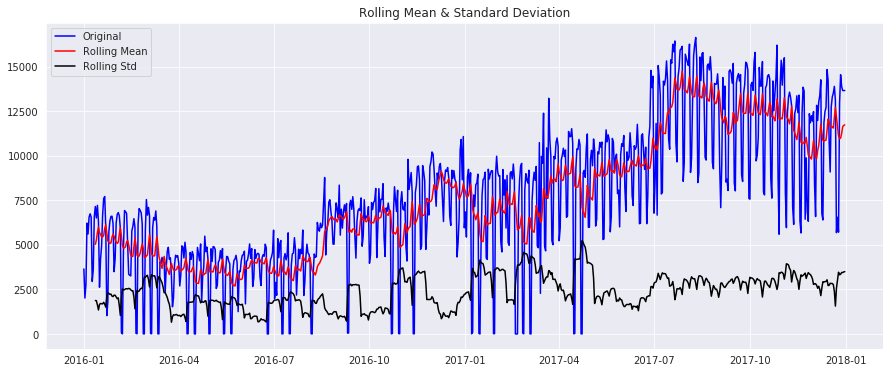

Results of Dickey-Fuller Test:
Test Statistic                  -0.521887
p-value                          0.887674
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


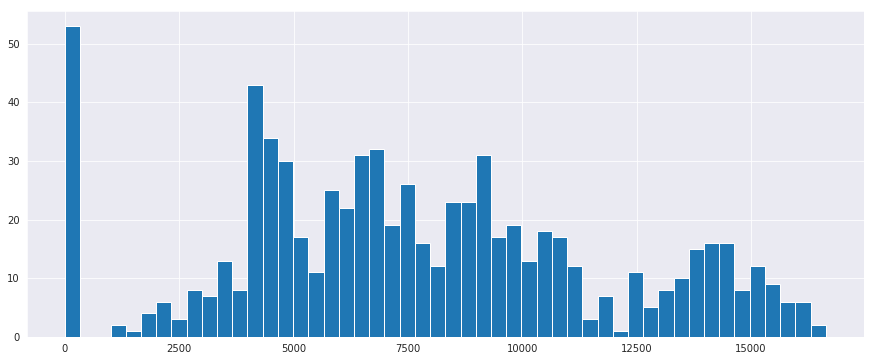

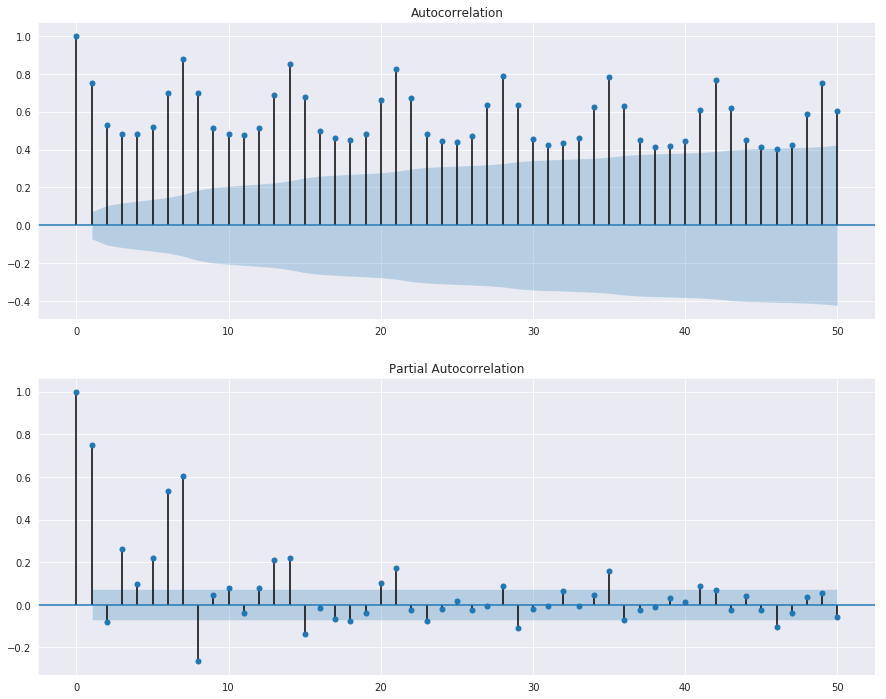

In [899]:
make_ts_plots(df_merged['delent'])

### Transit Passengers (entering the station)

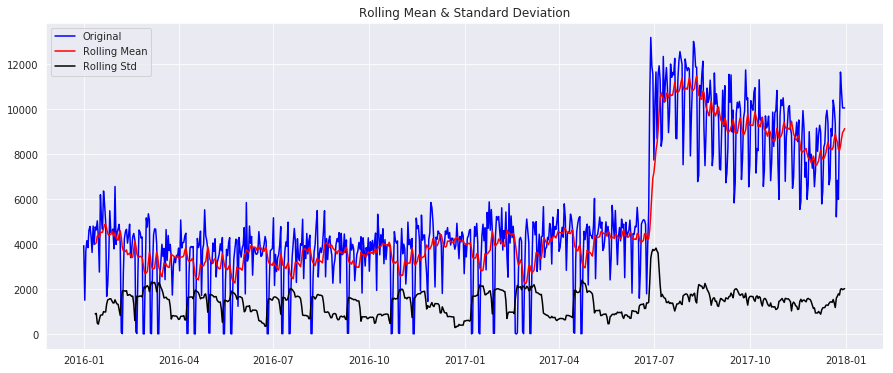

Results of Dickey-Fuller Test:
Test Statistic                  -0.706215
p-value                          0.845133
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


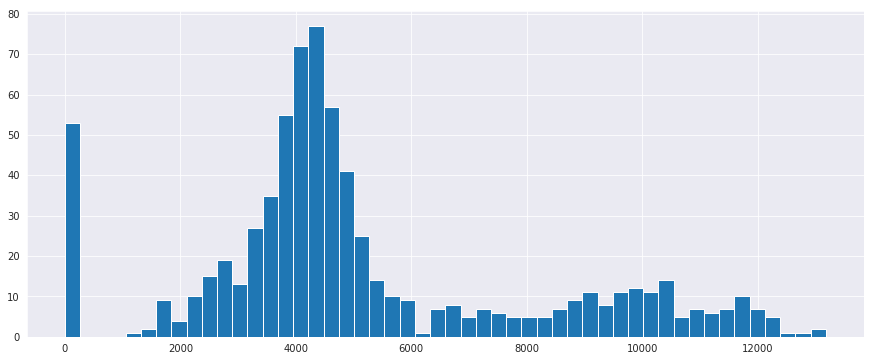

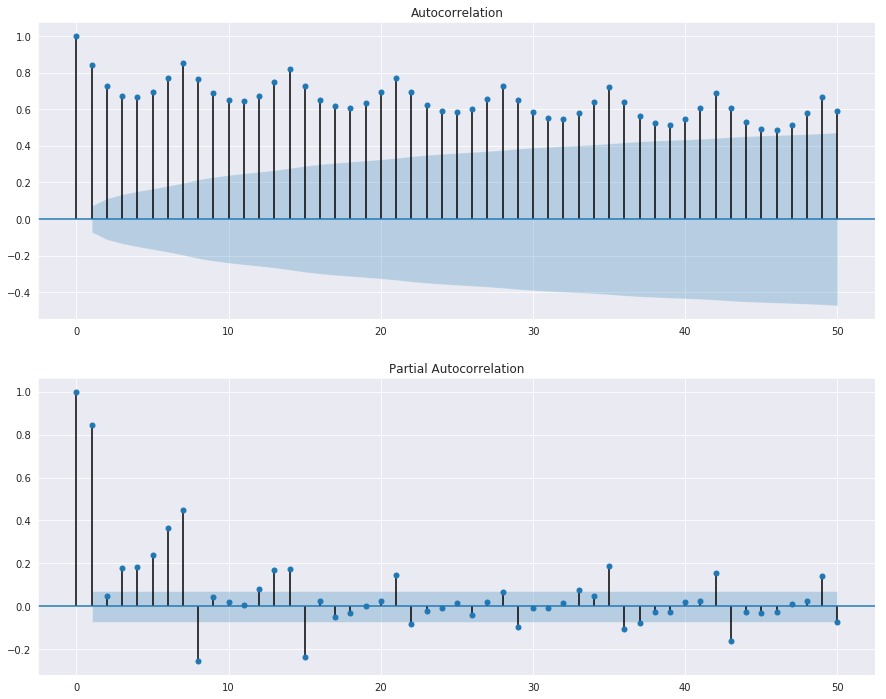

In [900]:
make_ts_plots(df_merged['delex'])

### Cab Rides

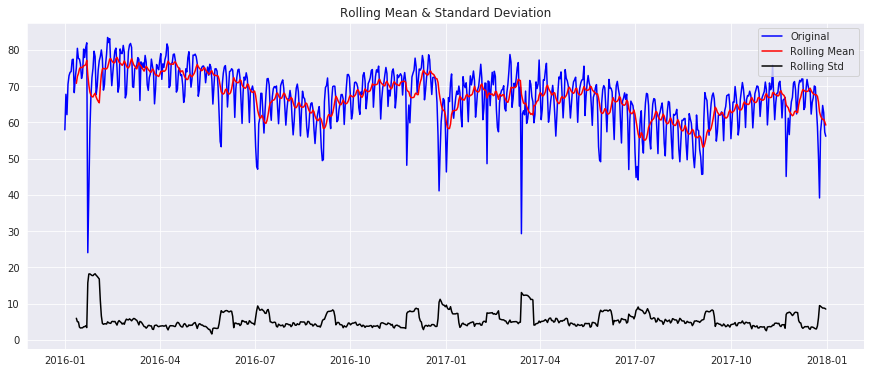

Results of Dickey-Fuller Test:
Test Statistic                  -2.492428
p-value                          0.117328
#Lags Used                      20.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


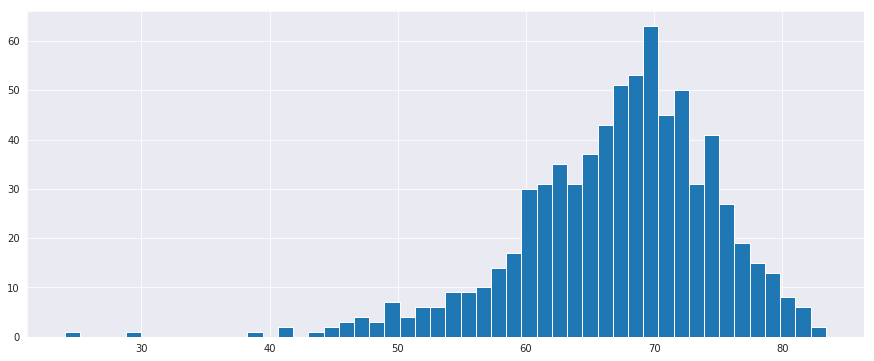

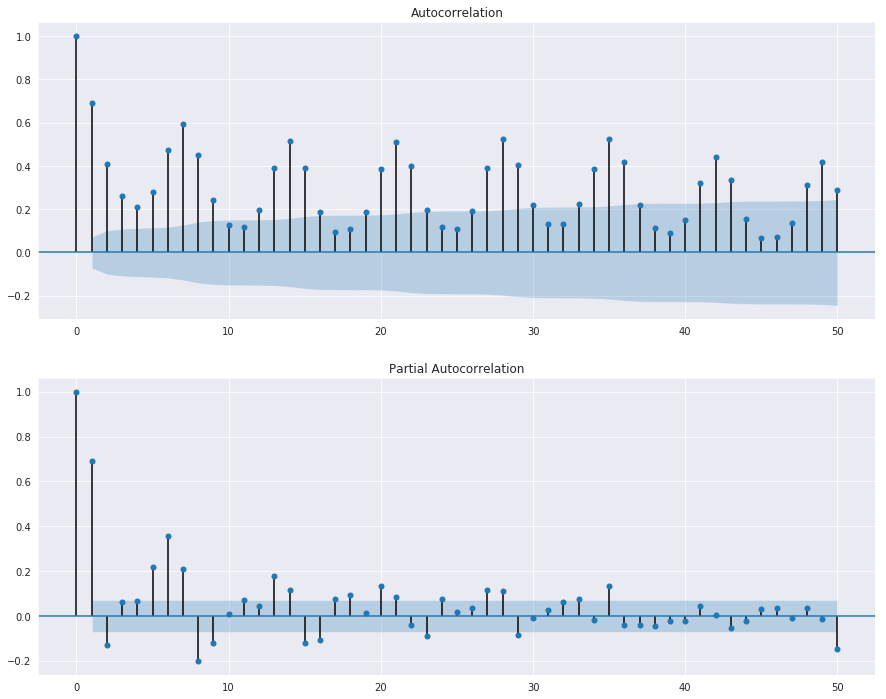

In [901]:
make_ts_plots(df_merged['passengers'])

### Traffic Speed

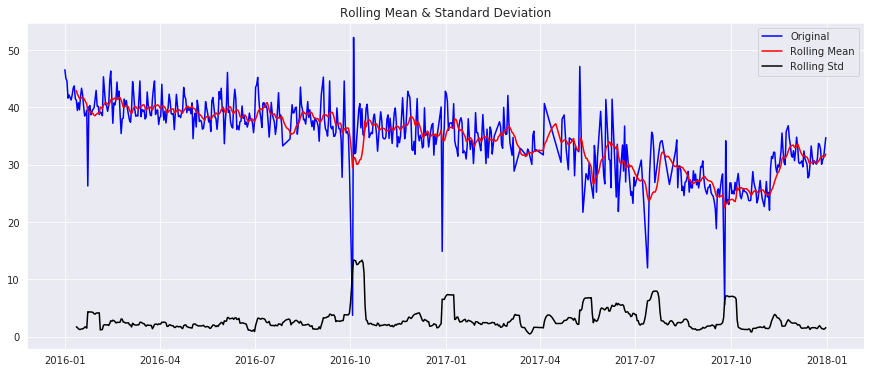

Results of Dickey-Fuller Test:
Test Statistic                  -2.218290
p-value                          0.199674
#Lags Used                      13.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


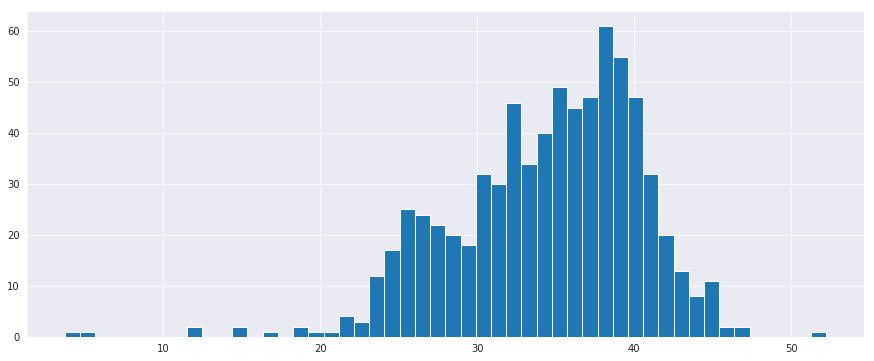

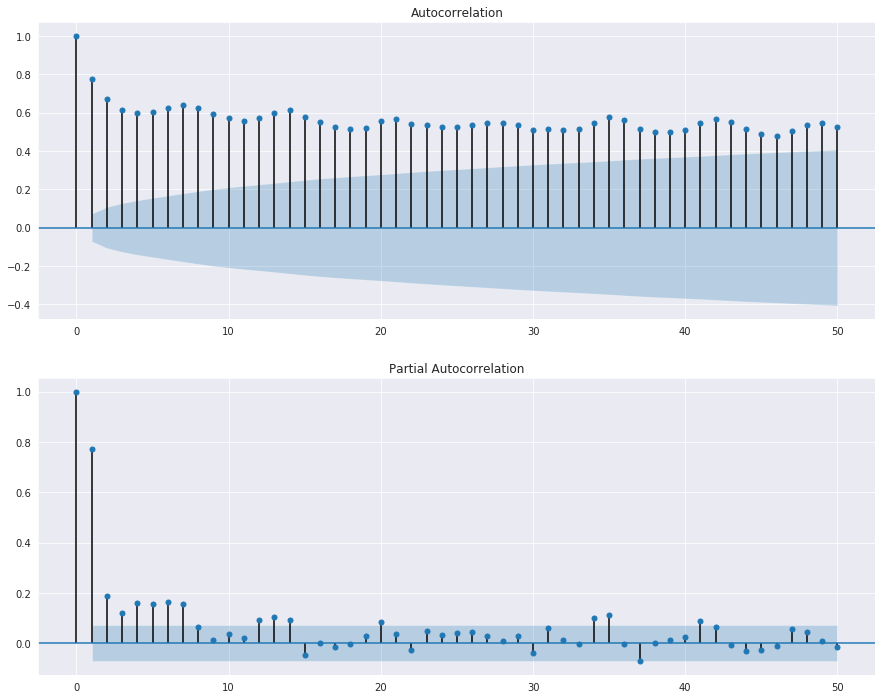

In [902]:
make_ts_plots(df_merged['speed'])

### Gas Price

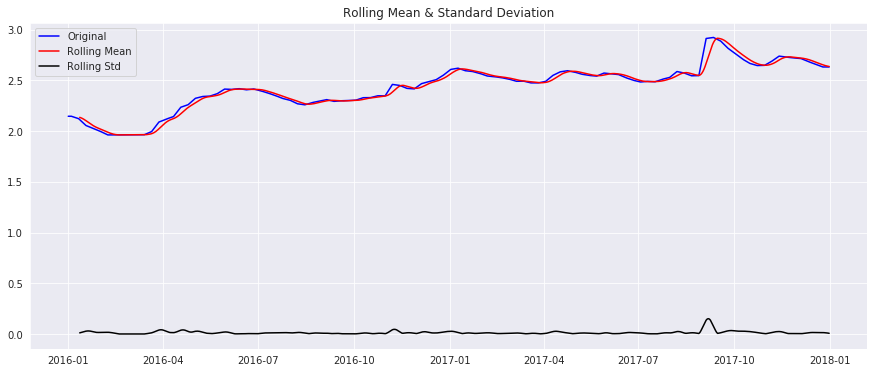

Results of Dickey-Fuller Test:
Test Statistic                  -1.954157
p-value                          0.307028
#Lags Used                      15.000000
Number of Observations Used    715.000000
Critical Value (1%)             -3.439529
Critical Value (5%)             -2.865591
Critical Value (10%)            -2.568927
dtype: float64


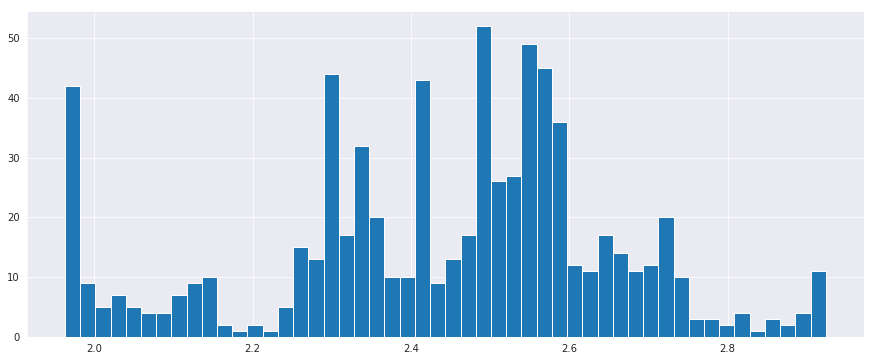

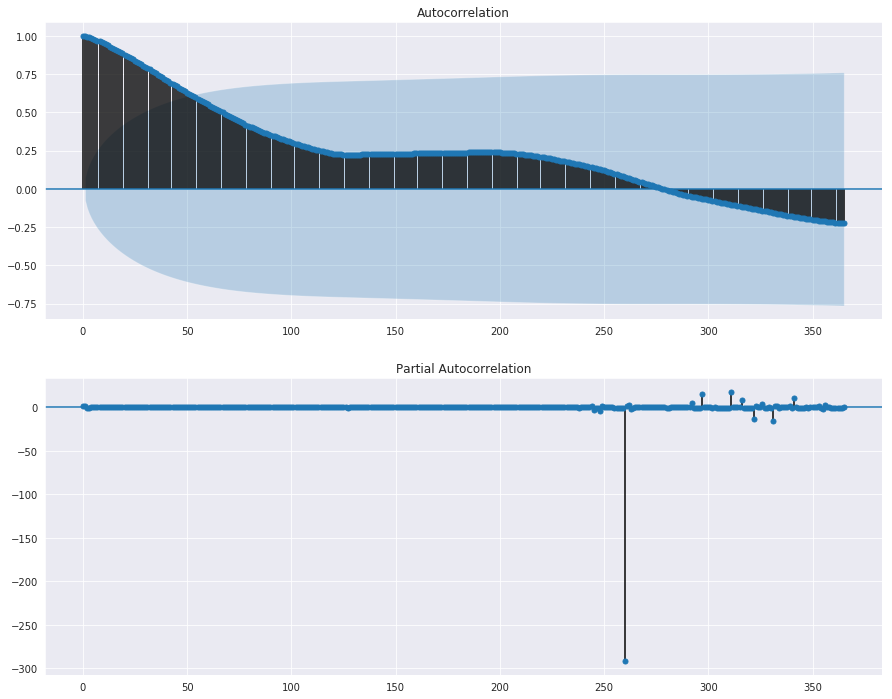

In [903]:
make_ts_plots(df_merged['price'], lag=365)

### Weather Temperature

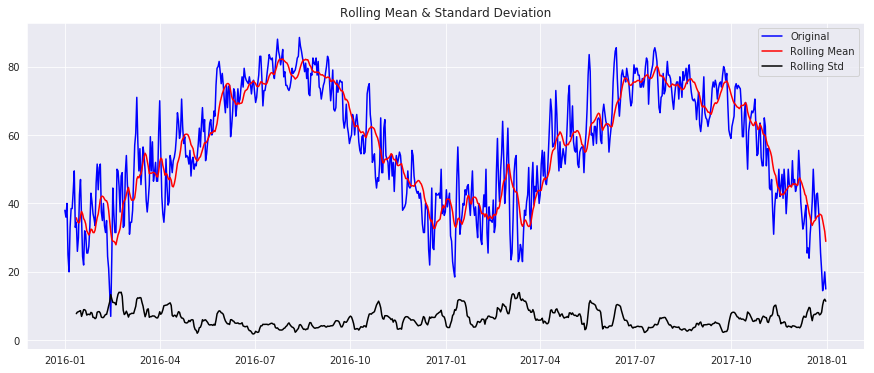

Results of Dickey-Fuller Test:
Test Statistic                  -1.220396
p-value                          0.664761
#Lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


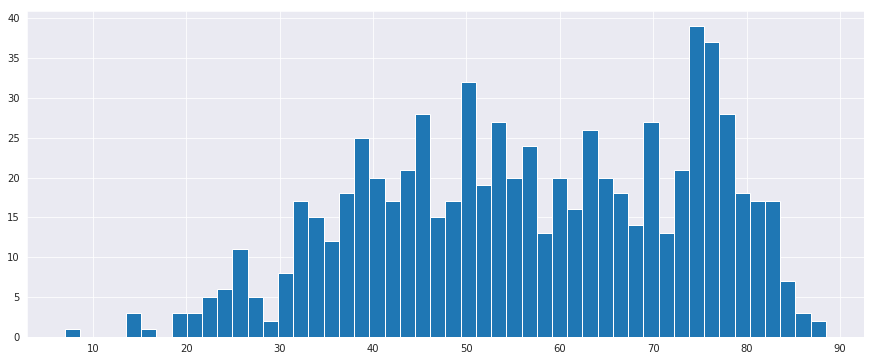

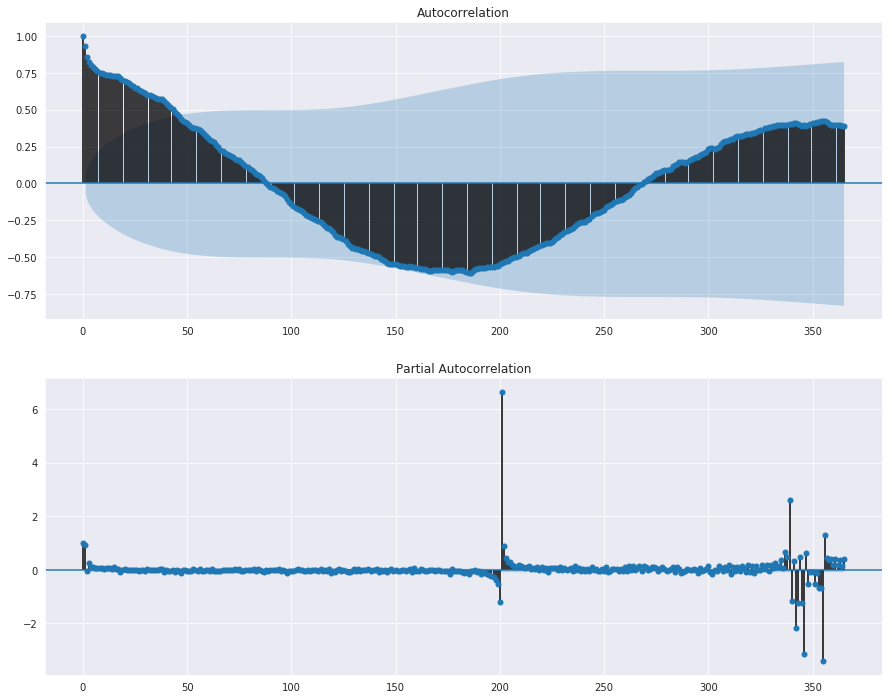

In [904]:
make_ts_plots(df_merged['temp'], lag=365)

### Transform each Series to make Stationary
#### (using log of difference with suitable time lag period for each series)

In [905]:
def smooth_log_diff(series, lag=1):
    series = log(series).diff(periods=lag)
    return series

In [906]:
def drop_inf_na(series):    
    series = series.replace([inf, -inf], nan).dropna()
    return series

In [907]:
from numpy import polyfit
def smooth_poly(series, degree=2):
    X = [i%365 for i in range(0, len(series))]
    y = series
    coef = polyfit(X, y, degree)
    y_hat = []
    for i in range(len(X)):
        value = coef[-1]
        for d in range(degree):
            value += X[i]**(degree-d) * coef[d]
        y_hat.append(value)
    values = series.values
    diff = []
    for i in range(len(values)):
        value = values[i] - y_hat[i]
        diff.append(value)
    return diff

In [908]:
from scipy.stats import boxcox, boxcox_normmax
import numpy as np 
def smooth_boxcox_diff(series):
    series_min = np.min(series)
    shift = 0.0
    if series_min <= 0:
        shift = - (series_min-1)
        series = series + shift
    lmbda = boxcox_normmax(series.values)
    series = Series(boxcox(series.values, lmbda=lmbda), index=series.index)
    return series, shift, lmbda

In [909]:
def smooth_diff(series, diff_lag=1):
    series = series.diff(periods=diff_lag)
    return series

In [910]:
def smooth_transform(series, diff_lag=1, boxcox=False):
    if boxcox:
        result = smooth_boxcox_diff(series)
    else:
        result = smooth_diff(series, diff_lag), 0, 0
    return result

#### Inverse Transform

In [911]:
# inverse diff
def inverse_diff(y_hat_trnsfmd, y_init, diff_lag):
    df = DataFrame(y_hat_trnsfmd.values, columns=['y_hat_trnsfmd'])
    init_len = diff_lag
    df = df.iloc[init_len:]
    df_init = DataFrame(y_init.values, columns=['y_hat_trnsfmd'])
    df = concat([df_init, df])
    df['y_hat'] = df['y_hat_trnsfmd']
    for idx in df.index:
        if idx >= diff_lag:
            df['y_hat'].iloc[idx] = df['y_hat_trnsfmd'].iloc[idx] + df['y_hat'].iloc[idx-diff_lag]
    df.index = y_hat_trnsfmd.index
    return df['y_hat']

### Transit Passengers (exiting the station)
#### lag = 7

In [912]:
df_t = DataFrame(index=df_merged.index)
#shifts = dict(zip(['delex','delent','cabs','traffic','gas','weather'],[0,0,0,0,0,0]))
#lmbdas = shifts

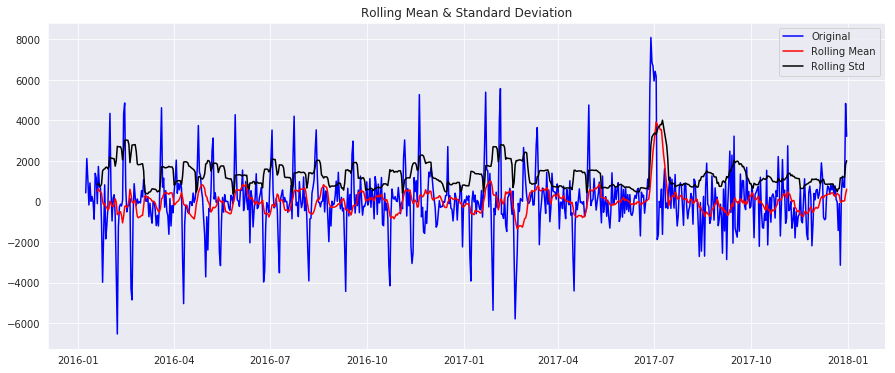

Results of Dickey-Fuller Test:
Test Statistic                -7.072427e+00
p-value                        4.898081e-10
#Lags Used                     1.400000e+01
Number of Observations Used    7.090000e+02
Critical Value (1%)           -3.439607e+00
Critical Value (5%)           -2.865625e+00
Critical Value (10%)          -2.568945e+00
dtype: float64


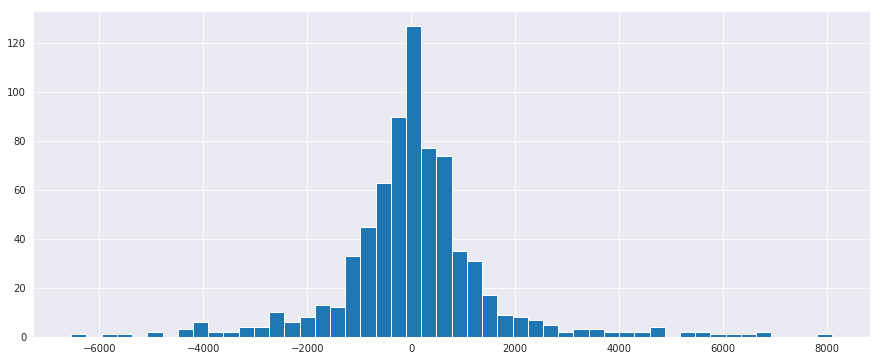

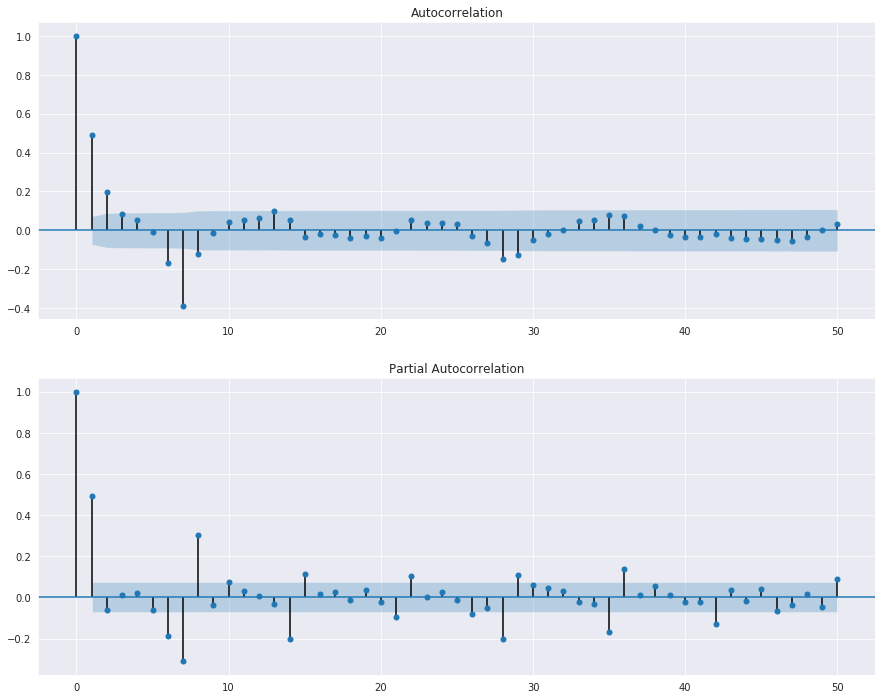

In [913]:
#df_merged['delex_diff1'] = smooth_log_diff(df_merged['delex'], lag=7)
#boxcox_result = smooth_transform(df_merged['delex'], diff_lag=7, boxcox=False)
df_t['delex'] = smooth_diff(df_merged['delex'], diff_lag=7)
#shifts['delex'] = boxcox_result[1]
#lmbdas['delex'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['delex']))

### Transit Passengers (entering the station)
#### lag = 7

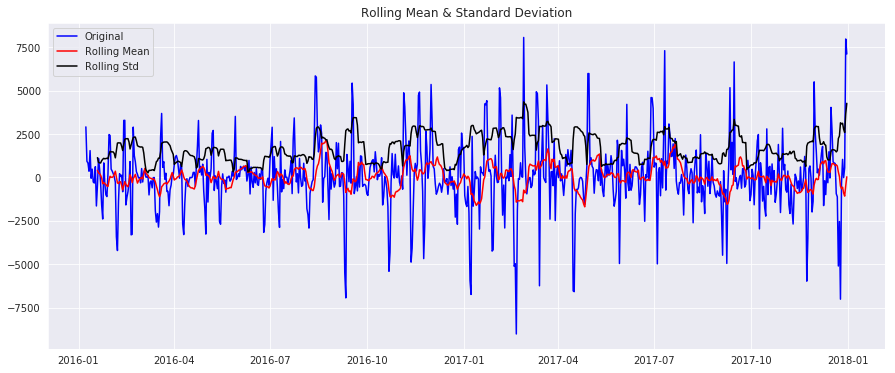

Results of Dickey-Fuller Test:
Test Statistic                -6.694682e+00
p-value                        4.027424e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


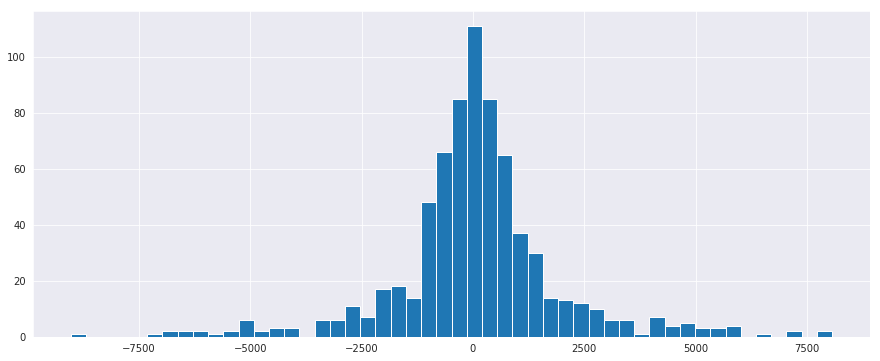

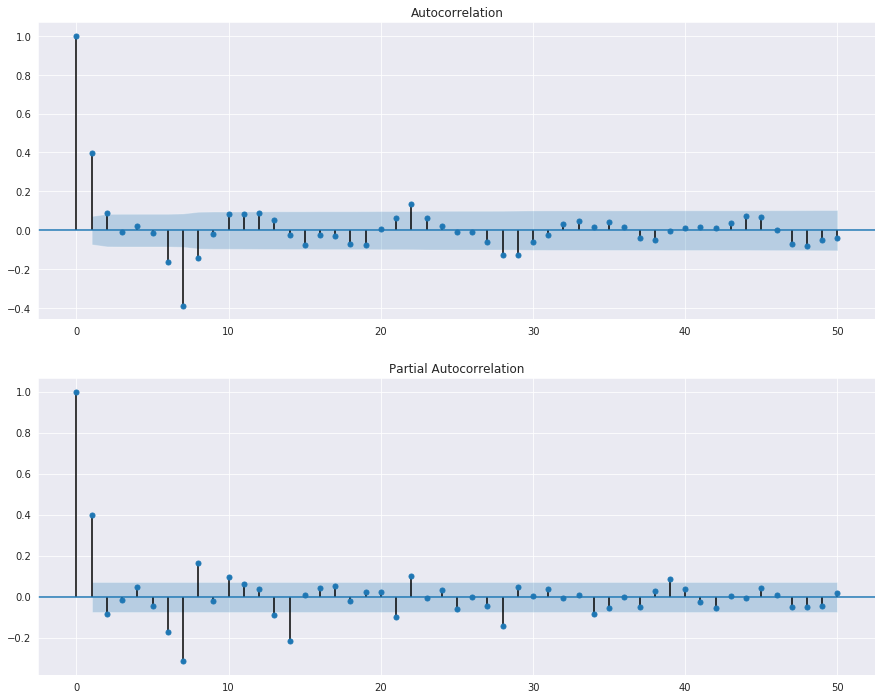

In [914]:
#df_merged['delent_diff1'] = smooth_log_diff(df_merged['delent'], lag=7)
#boxcox_result = smooth_transform(df_merged['delent'], diff_lag=7, boxcox=False)
df_t['delent'] = smooth_diff(df_merged['delent'], diff_lag=7)
#shifts['delent'] = boxcox_result[1]
#lmbdas['delent'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['delent']))

### Cab Rides
#### lag = 7

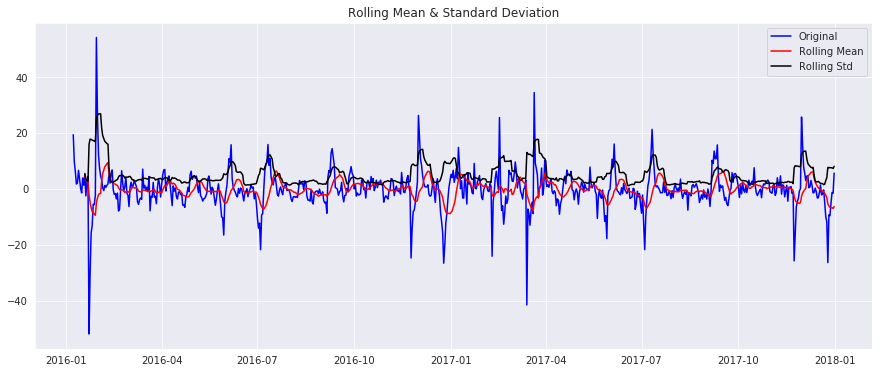

Results of Dickey-Fuller Test:
Test Statistic                -9.888122e+00
p-value                        3.618041e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


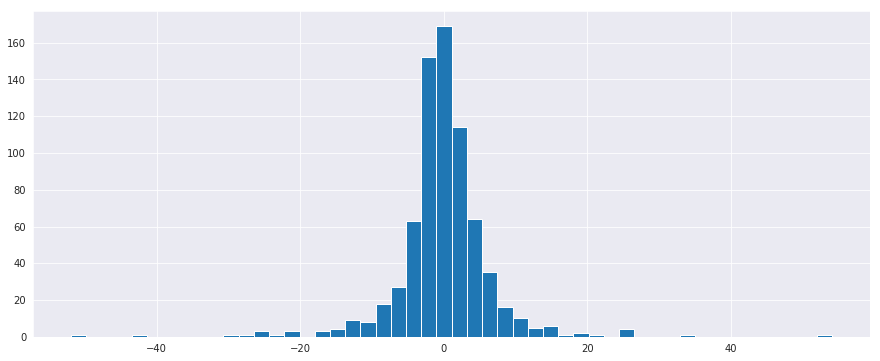

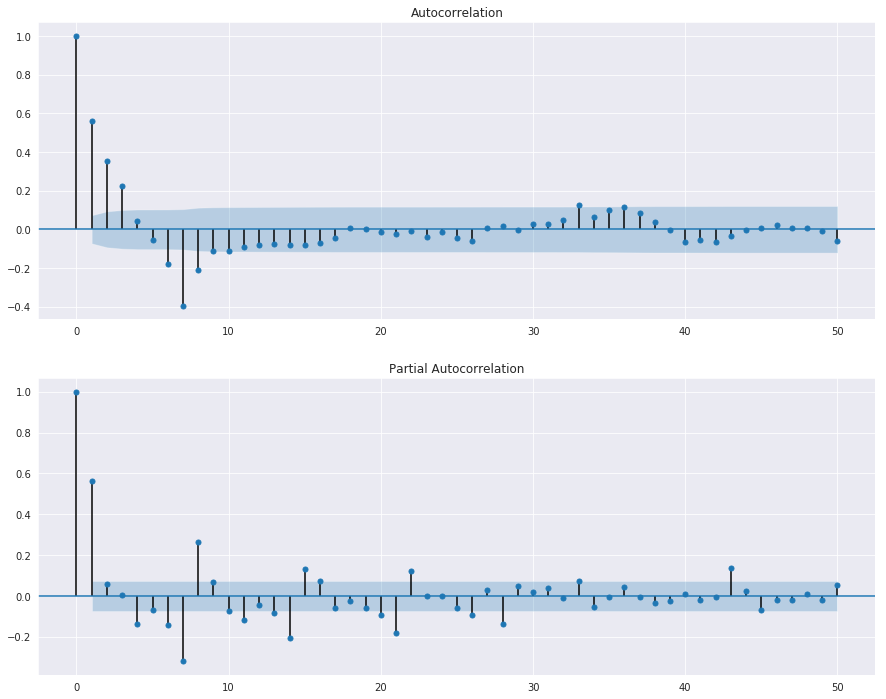

In [915]:
#df_merged['cabs_diff1'] = smooth_log_diff(df_merged['passengers'], lag=7)
#boxcox_result = smooth_transform(df_merged['passengers'], diff_lag=7, boxcox=False)
df_t['cabs'] = smooth_diff(df_merged['passengers'], diff_lag=7)
#shifts['cabs'] = boxcox_result[1]
#lmbdas['cabs'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['cabs']))

### Traffic Speed
#### lag = 7

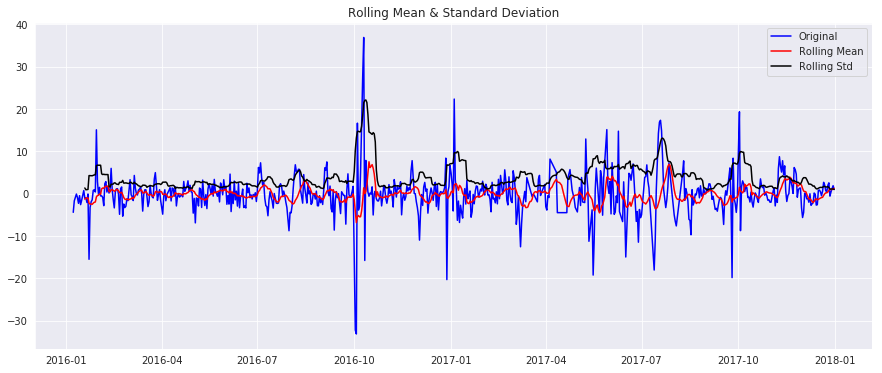

Results of Dickey-Fuller Test:
Test Statistic                -8.729777e+00
p-value                        3.215026e-14
#Lags Used                     2.000000e+01
Number of Observations Used    7.030000e+02
Critical Value (1%)           -3.439686e+00
Critical Value (5%)           -2.865660e+00
Critical Value (10%)          -2.568964e+00
dtype: float64


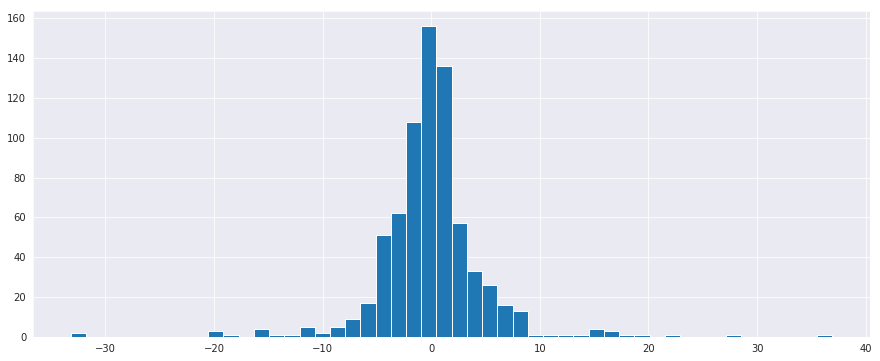

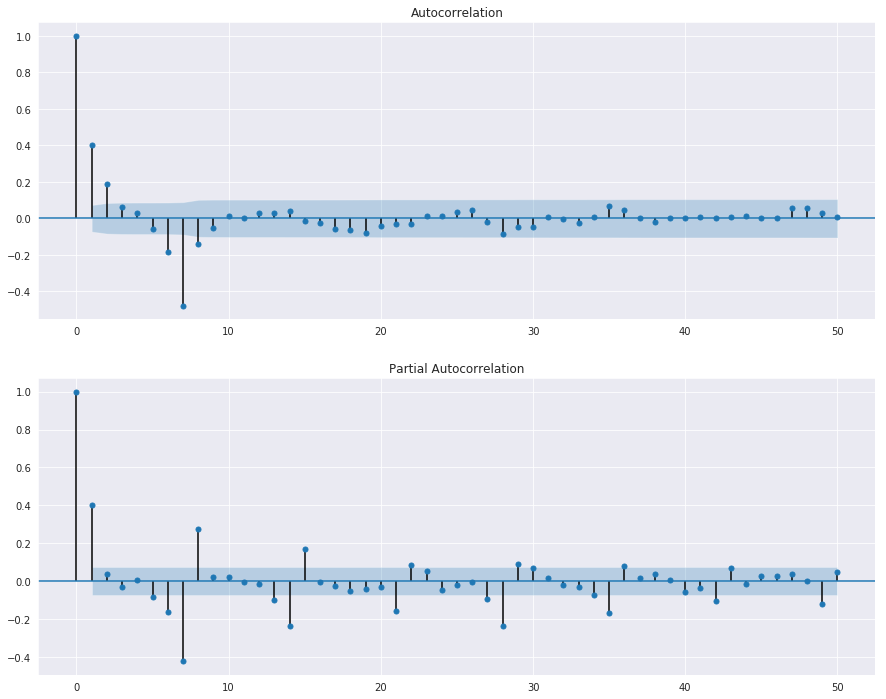

In [916]:
#df_merged['traffic_diff1'] = smooth_log_diff(df_merged['speed'], lag=7)
#boxcox_result = smooth_transform(df_merged['speed'], diff_lag=7, boxcox=False)
df_t['traffic'] = smooth_diff(df_merged['speed'], diff_lag=7)
#shifts['traffic'] = boxcox_result[1]
#lmbdas['traffic'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['traffic']))

### Gas Price

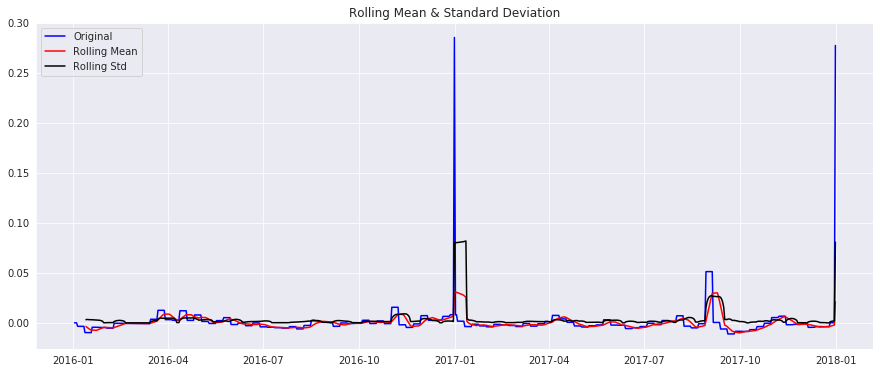

Results of Dickey-Fuller Test:
Test Statistic                -7.946531e+00
p-value                        3.208881e-12
#Lags Used                     2.000000e+00
Number of Observations Used    7.270000e+02
Critical Value (1%)           -3.439377e+00
Critical Value (5%)           -2.865524e+00
Critical Value (10%)          -2.568891e+00
dtype: float64


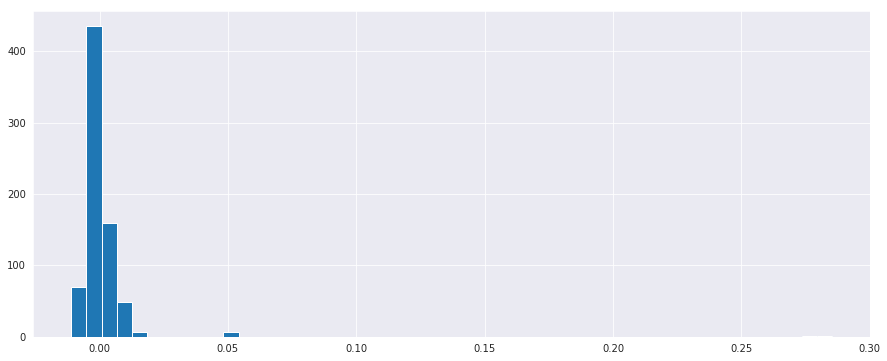

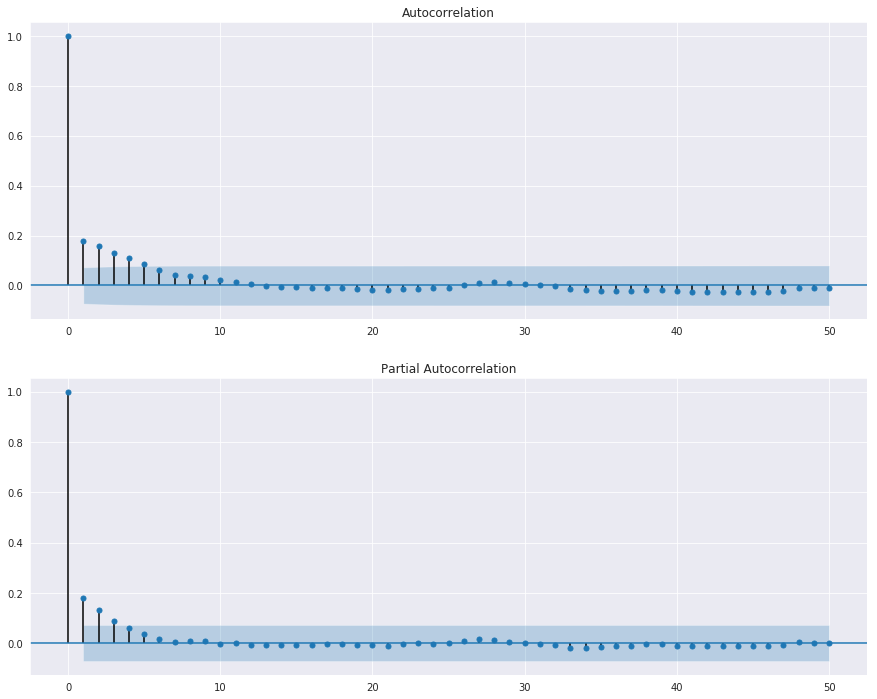

In [917]:
df_t['gas'] = smooth_poly(df_merged['price'], degree=3)
#boxcox_result = smooth_transform(df_t['gas'], diff_lag=7, boxcox=True)
df_t['gas'] = smooth_diff(df_t['gas'], diff_lag=1)
#shifts['gas'] = boxcox_result[1]
#lmbdas['gas'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['gas']))

### Weather Temperature

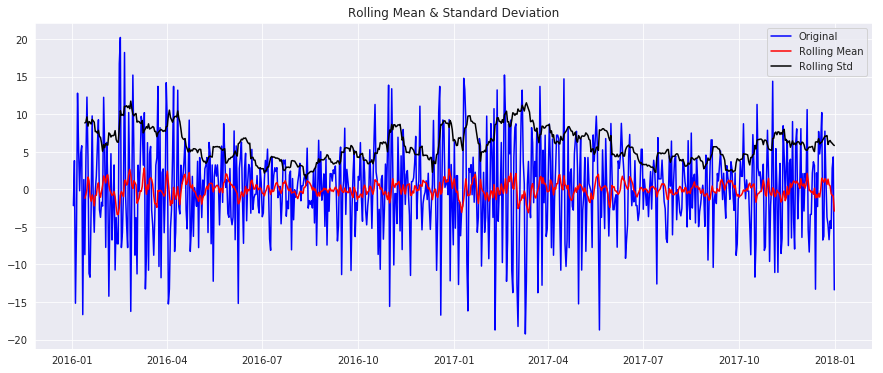

Results of Dickey-Fuller Test:
Test Statistic                -1.124053e+01
p-value                        1.811857e-20
#Lags Used                     1.500000e+01
Number of Observations Used    7.140000e+02
Critical Value (1%)           -3.439542e+00
Critical Value (5%)           -2.865596e+00
Critical Value (10%)          -2.568930e+00
dtype: float64


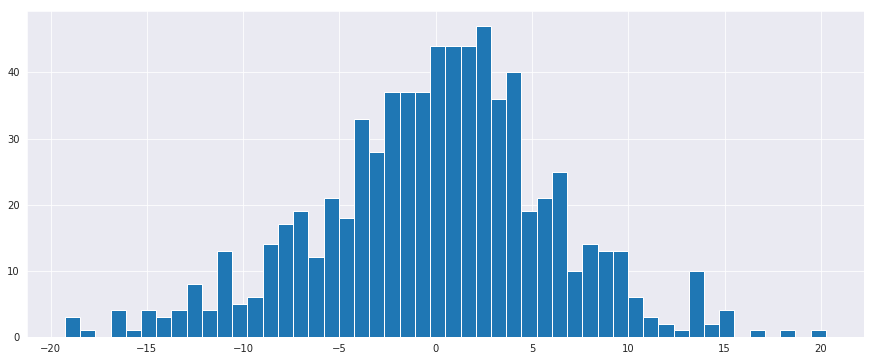

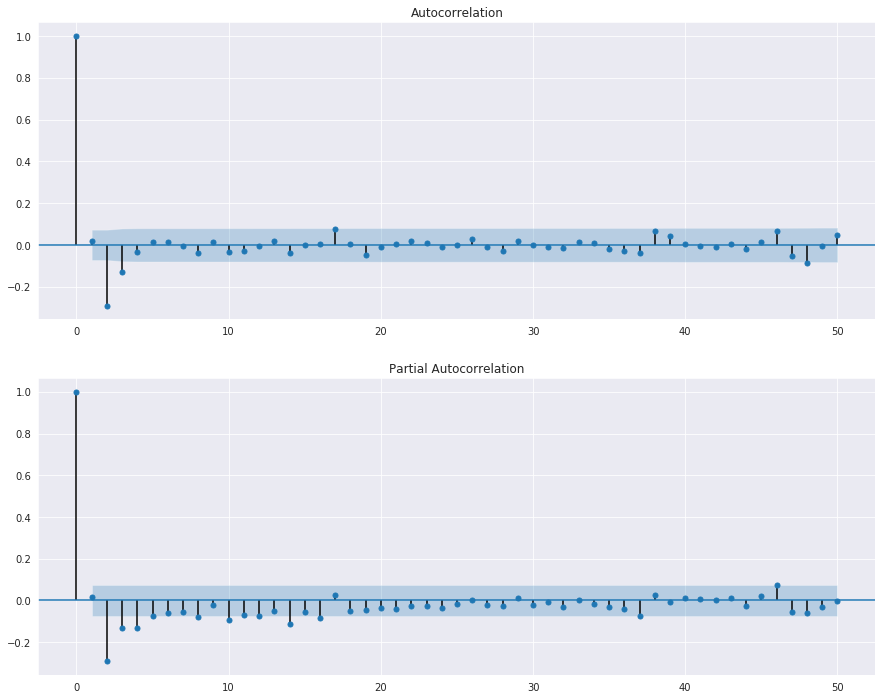

In [918]:
df_t['weather'] = smooth_poly(df_merged['temp'], degree=3)
#boxcox_result = smooth_transform(df_merged['temp'], diff_lag=7, boxcox=False)
df_t['weather'] = smooth_diff(df_t['weather'], diff_lag=1)
#shifts['weather'] = boxcox_result[1]
#lmbdas['weather'] = boxcox_result[2]
make_ts_plots(drop_inf_na(df_t['weather']))

In [919]:
df_t.head(20)

,delex,delent,cabs,traffic,gas,weather
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,0.000065,-2.160282
2016-01-03,NaN,NaN,NaN,NaN,0.000050,3.837263
2016-01-04,NaN,NaN,NaN,NaN,0.000036,-15.165163
2016-01-05,NaN,NaN,NaN,NaN,-0.003407,-5.167560
2016-01-06,NaN,NaN,NaN,NaN,-0.003421,12.830072
2016-01-07,NaN,NaN,NaN,NaN,-0.003435,5.327732
2016-01-08,430.0,2908.0,19.354067,-4.405692,-0.003450,-0.174579
2016-01-09,2123.0,930.0,9.689660,-1.689922,-0.003463,4.823139
2016-01-10,1101.0,822.0,6.070938,-0.868492,-0.003477,5.820885


### Train-Test Split

In [920]:
def interpolate_inf_na(df):
    df = df.replace([inf, -inf], nan).interpolate('time', limit_direction='both')
    return df    

In [921]:
df_t.loc[df_t.isin([inf,nan]).any(axis=1)]

,delex,delent,cabs,traffic,gas,weather
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,0.000065,-2.160282
2016-01-03,NaN,NaN,NaN,NaN,0.000050,3.837263
2016-01-04,NaN,NaN,NaN,NaN,0.000036,-15.165163
2016-01-05,NaN,NaN,NaN,NaN,-0.003407,-5.167560
2016-01-06,NaN,NaN,NaN,NaN,-0.003421,12.830072
2016-01-07,NaN,NaN,NaN,NaN,-0.003435,5.327732


In [922]:
df_t = interpolate_inf_na(df_t)
df_t.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      731 non-null float64
delent     731 non-null float64
cabs       731 non-null float64
traffic    731 non-null float64
gas        731 non-null float64
weather    731 non-null float64
dtypes: float64(6)
memory usage: 40.0 KB


In [923]:
train = df_t.loc[:'2017-06-30'][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]
test = df_t.loc['2017-07-01':][['delex','delent', 'cabs', 'traffic', 'gas', 'weather']]

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2016-01-01 to 2017-06-30
Freq: D
Data columns (total 6 columns):
delex      547 non-null float64
delent     547 non-null float64
cabs       547 non-null float64
traffic    547 non-null float64
gas        547 non-null float64
weather    547 non-null float64
dtypes: float64(6)
memory usage: 29.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2017-07-01 to 2017-12-31
Freq: D
Data columns (total 6 columns):
delex      184 non-null float64
delent     184 non-null float64
cabs       184 non-null float64
traffic    184 non-null float64
gas        184 non-null float64
weather    184 non-null float64
dtypes: float64(6)
memory usage: 10.1 KB


In [924]:
train_y = train[['delex','delent']]
train_x = train[['cabs', 'traffic', 'gas', 'weather']]
test_y = test[['delex','delent']]
test_x = test[['cabs', 'traffic', 'gas', 'weather']]

### Applying VAR Model

In [925]:
def make_var_plots(var_result, index=0):
    #fig, ax = plt.subplots(figsize=(15,12))
    var_result.plot_diagnostics(variable=index, figsize=(15,12))
    return

In [926]:
from statsmodels.tsa.statespace.varmax import VARMAX

### Model Selection

In [927]:
from numpy import zeros
p_max = 5
q_max =5
aic = DataFrame(zeros((p_max,q_max), dtype=float))
bic = DataFrame(zeros((p_max,q_max), dtype=float))
for p in range(1,p_max+1):
    for q in range(1,q_max+1):
        var_model = VARMAX(train_y, train_x, order=(p,q),  enforce_invertibility=True)
        try:
            var_model_result = var_model.fit(maxiter=100, disp=False)
            #print('order = {:d},{:d}'.format(p,q))
            aic.iloc[p-1,q-1] = var_model_result.aic
            bic.iloc[p-1,q-1] = var_model_result.bic
        except:
            aic.iloc[p-1,q-1] = nan
            bic.iloc[p-1,q-1] = nan

In [928]:
q = aic.min().idxmin()
p = aic.idxmin()[q]
print('optimum order = {:d},{:d}'.format(p,q))

optimum order = 3,4


In [929]:
var_model = VARMAX(train_y, train_x, order=(p,q),  enforce_invertibility=True)
var_model_result = var_model.fit(maxiter=5000, disp=False)
print(var_model_result.summary())

                            Statespace Model Results                           
Dep. Variable:     ['delex', 'delent']   No. Observations:                  547
Model:                     VARMAX(3,4)   Log Likelihood               -9295.898
                           + intercept   AIC                          18673.797
Date:                 Mon, 19 Nov 2018   BIC                          18850.279
Time:                         22:05:19   HQIC                         18742.780
Sample:                     01-01-2016                                         
                          - 06-30-2017                                         
Covariance Type:                   opg                                         
Ljung-Box (Q):               107.19, 53.75   Jarque-Bera (JB):        83.34, 186.44
Prob(Q):                        0.00, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.29, 3.66   Skew:                      0.24, -0.45
Prob(H) (two-sided):        

### Transit Passengers (exiting the station)

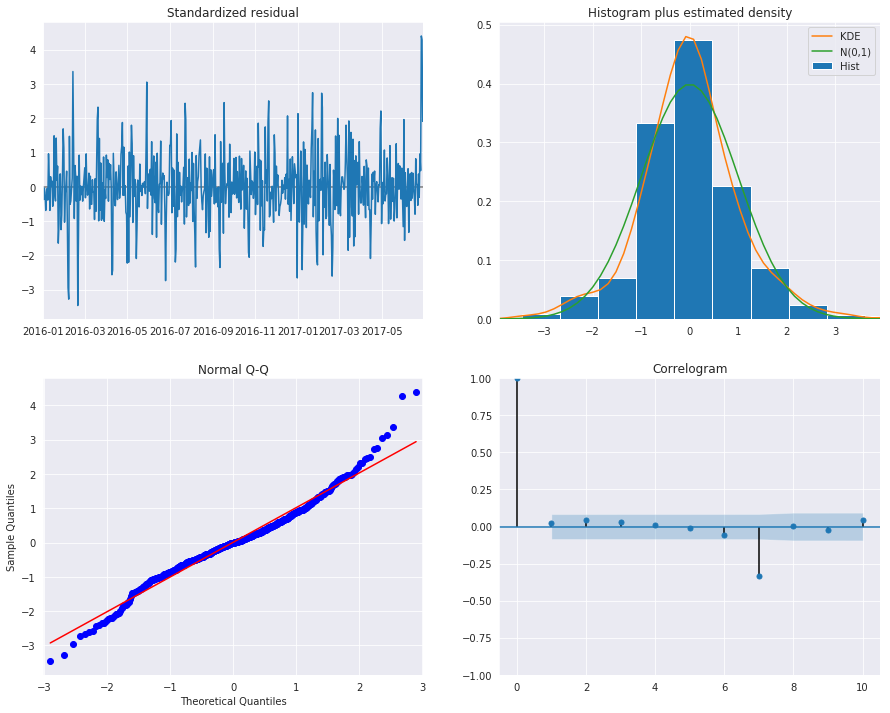

In [930]:
make_var_plots(var_model_result, index=0)

### Transit Passengers (entering the station)

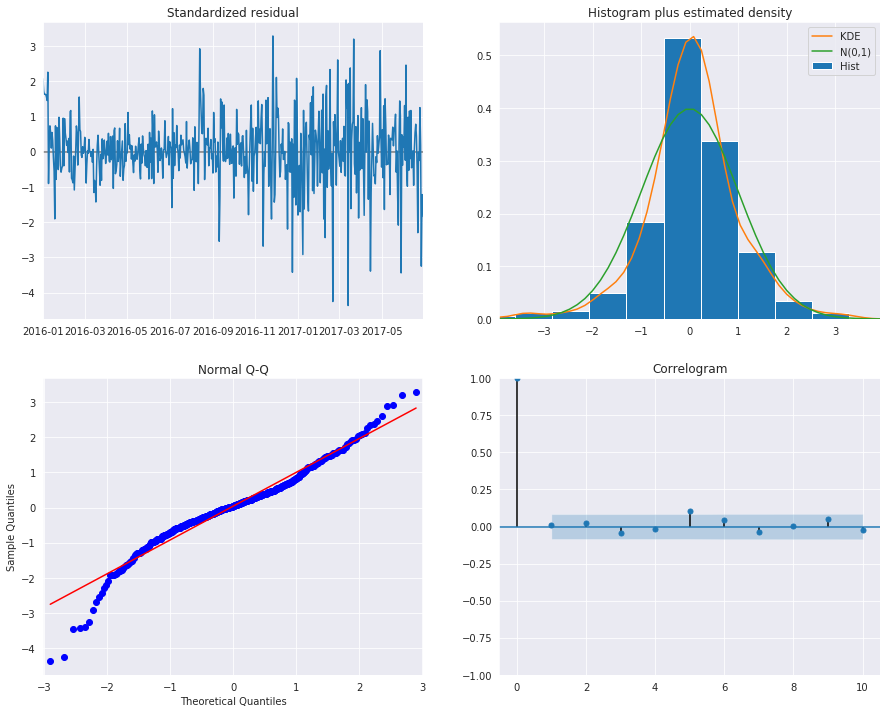

In [931]:
make_var_plots(var_model_result, index=1)

### Inverse Tranform
#### (Inverting the second-order difference transformation to retrieve predicted values in the original form)

$$\ddot y_t = \dot y_t - \dot y_{t-lag_2}$$
$$\dot y_t = \ddot y_t + \dot y_{t-lag_2}$$

$$\dot y_t = \log{y_t} - \log{y_{t-lag_1}} = \log{\frac{y_t}{y_{t-lag_1}}}$$
$$e^{\dot y_t} = \frac{y_t}{y_{t-lag_1}}$$
$$y_t = y_{t-lag_1} e^{\dot y_t} 
      = y_{t-lag_1} e^{\ddot y_t + \dot y_{t-lag_2}} 
      = y_{t-lag_1} e^{\ddot y_t} e^{\dot y_{t-lag_2}} 
      = y_{t-lag_1} e^{\ddot y_t} e^{\log{\frac{y_{t-lag_2}}{y_{t-lag_2-lag_1}}}} 
      = \frac{y_{t-lag_1}y_{t-lag_2}}{y_{t-lag_2-lag_1}} e^{\ddot y_t}$$

In [932]:
from numpy import exp
from pandas import Timedelta, to_datetime
# y_hat_transformed and y must have the same number of columns 
# (each column in y corresponding to a transformed column in y_hat_transformed)
# length and row-index of y_hat is same as length and row-index of y_hat_transformed
# first (lag1+lag2) number of rows of y_hat has same values as first (lag1+lag2) number of rows of y
def inverse_order2_transform(y_hat_transformed, y, lag_1, lag_2):
    y_hat = DataFrame(index=y_hat_transformed.index, columns=y.columns)
    td_1 = Timedelta(lag_1, unit='d')
    td_2 = Timedelta(lag_2, unit='d')
    idx0 = y_hat.index.to_series().iloc[0]
    print('start date ', idx0)
    initial_idx = (idx0+td_1+td_2-Timedelta(1, unit='d')).strftime('%Y-%m-%d')
    print('start date +lag1+lag2 ', initial_idx)
    #print('y_hat_transformed')
    #print(y_hat_transformed.head(20))
    #print('y')
    #print(y.head())
    y_hat.loc[:initial_idx] = y.loc[:initial_idx]
    #print('y_hat')
    #print(y_hat.head(10))
    initial_idx = (idx0+td_1+td_2).strftime('%Y-%m-%d')
    for col in y_hat.columns:
        col_idx = y_hat.columns.get_loc(col)
        df = DataFrame(index=y_hat.index)
        df['orig'] = y_hat[col]
        df['trnsfmd'] = y_hat_transformed.iloc[:,col_idx]
        df['lag_1'] = y_hat[col].shift(freq=td_1)
        df['lag_2'] = y_hat[col].shift(freq=td_2)
        df['lag_1+lag_2'] = y_hat[col].shift(freq=td_1+td_2)
        print(df.head(15))
        for i, idx in enumerate(y_hat.index.values) :
            if i >= (lag_1+lag_2):
                y_hat[col].loc[idx] = exp(y_hat_transformed.iloc[:,col_idx].loc[idx]) *\
                                               y_hat[col].loc[(idx-td_1).strftime('%Y-%m-%d')] *\
                                               y_hat[col].loc[(idx-td_2).strftime('%Y-%m-%d')] /\
                                               y_hat[col].loc[(idx-td_1-td_2).strftime('%Y-%m-%d')]
        
    
    print('y_hat')
    print(y_hat.head(20))
    return y_hat

### Forecasting

In [933]:
# Generate Exogenous Data for Forecasting
nforecast = len(test_x)
print('no. of training observations ',var_model_result.nobs)
print('no. of data-points to be forecast ',nforecast)

no. of training observations  547
no. of data-points to be forecast  184


In [934]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
predict = var_model_result.get_prediction(end=var_model_result.nobs + nforecast-1, exog = test_x)
""" idx = np.arange(len(predict.predicted_mean)) """
predict_ci95 = predict.conf_int(alpha=0.05)
predict_ci60 = predict.conf_int(alpha=0.4)
predict_ci30 = predict.conf_int(alpha=0.7)

In [935]:
pred_mean = predict.predicted_mean

### Invert Transformation

In [936]:
from pandas import Timedelta
y_cols = ['delex','delent']
lag=7
td = Timedelta(lag, unit='d')
idx0 = df_merged.index.to_series().iloc[0]
initial_idx = (idx0+td-Timedelta(1, unit='d')).strftime('%Y-%m-%d')
pred_mean_inv = DataFrame(index=pred_mean.index, columns=y_cols)
for col in y_cols:
    pred_mean_inv[col] = inverse_diff(pred_mean[col], df_merged[col].loc[:initial_idx], diff_lag=lag)
pred_mean_inv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-01-01 to 2017-12-31
Freq: D
Data columns (total 2 columns):
delex     731 non-null float64
delent    731 non-null float64
dtypes: float64(2)
memory usage: 17.1 KB


In [937]:
#pred_mean_inv.loc[pred_mean_inv.isna().any(axis=1)]
pred_mean_inv.describe()

,delex,delent
count,731.000000,731.000000
mean,5428.247083,6671.469093
std,2820.824739,3379.631447
min,-932.124604,-580.681391
25%,3745.984206,4366.489311
50%,4789.292159,6218.643538
75%,6449.856492,9085.657510
max,14554.684246,16113.994714


In [938]:
def make_prediction_plot(df, train_y, test_y, predict, y_column):
    train_y = df.loc[train_y.index][[y_column]]
    test_y = df.loc[test_y.index][[y_column]]
    nforecast = len(test_y)
    df = concat([train_y, test_y])
    idx = df.index
    # Graph
    fig, ax = plt.subplots(figsize=(18,18))
    ax.grid()
    ax.plot(idx,df,'k',label='', alpha=1, linewidth=0.75)
    ax.plot(idx,df,'k.', label='Actual Values', alpha=1, linewidth=0.75)
    
    pred_mean=predict.predicted_mean[[y_column]]
    lag=7
    td = Timedelta(lag, unit='d')
    idx0 = df.index.to_series().iloc[0]
    initial_idx = (idx0+td-Timedelta(1, unit='d')).strftime('%Y-%m-%d')
    pred_mean_inv = DataFrame(index=pred_mean.index, columns=[y_column])
    pred_mean_inv[y_column] = inverse_diff(pred_mean[y_column], df[y_column].loc[:initial_idx], diff_lag=lag)
    offset = pred_mean_inv[y_column] - pred_mean[y_column]
    offset=0
    predict_ci95 = predict.conf_int(alpha=0.05)
    predict_ci60 = predict.conf_int(alpha=0.4)
    predict_ci30 = predict.conf_int(alpha=0.7)
    lower = 'lower '+y_column
    upper = 'upper '+y_column
    predict_ci95_lower = predict_ci95[lower] + offset
    predict_ci60_lower = predict_ci60[lower] + offset
    predict_ci30_lower = predict_ci30[lower] + offset
    predict_ci95_upper = predict_ci95[upper] + offset
    predict_ci60_upper = predict_ci60[upper] + offset
    predict_ci30_upper = predict_ci30[upper] + offset
    
    # Plot
    ax.plot(train_y.index, pred_mean_inv[:-nforecast], color='blue',alpha=0.7, label='Train-Set Prediction')
    ax.plot(test_y.index, pred_mean_inv[-nforecast:], 'k--', color='red', alpha=0.7, linestyle='--', linewidth=1.5,label='Test-Set Prediction')
    
    ax.plot(train_y.index, pred_mean[:-nforecast], color='blue',alpha=0.7, label='Train-Set Prediction')
    ax.plot(test_y.index, pred_mean[-nforecast:], 'k--', color='red', alpha=0.7, linestyle='--', linewidth=1.5,label='Test-Set Prediction')
    #if inverse_trans_func is None:
    ax.fill_between(test_y.index, predict_ci95_lower.iloc[-nforecast:], 
                    predict_ci95_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci60_lower.iloc[-nforecast:], 
                    predict_ci60_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.fill_between(test_y.index, predict_ci30_lower.iloc[-nforecast:], 
                    predict_ci30_upper.iloc[-nforecast:], alpha=0.15, label= '')
    ax.legend()
    ax.set(title='VARMAX - Forecasting');
    plt.show(fig)

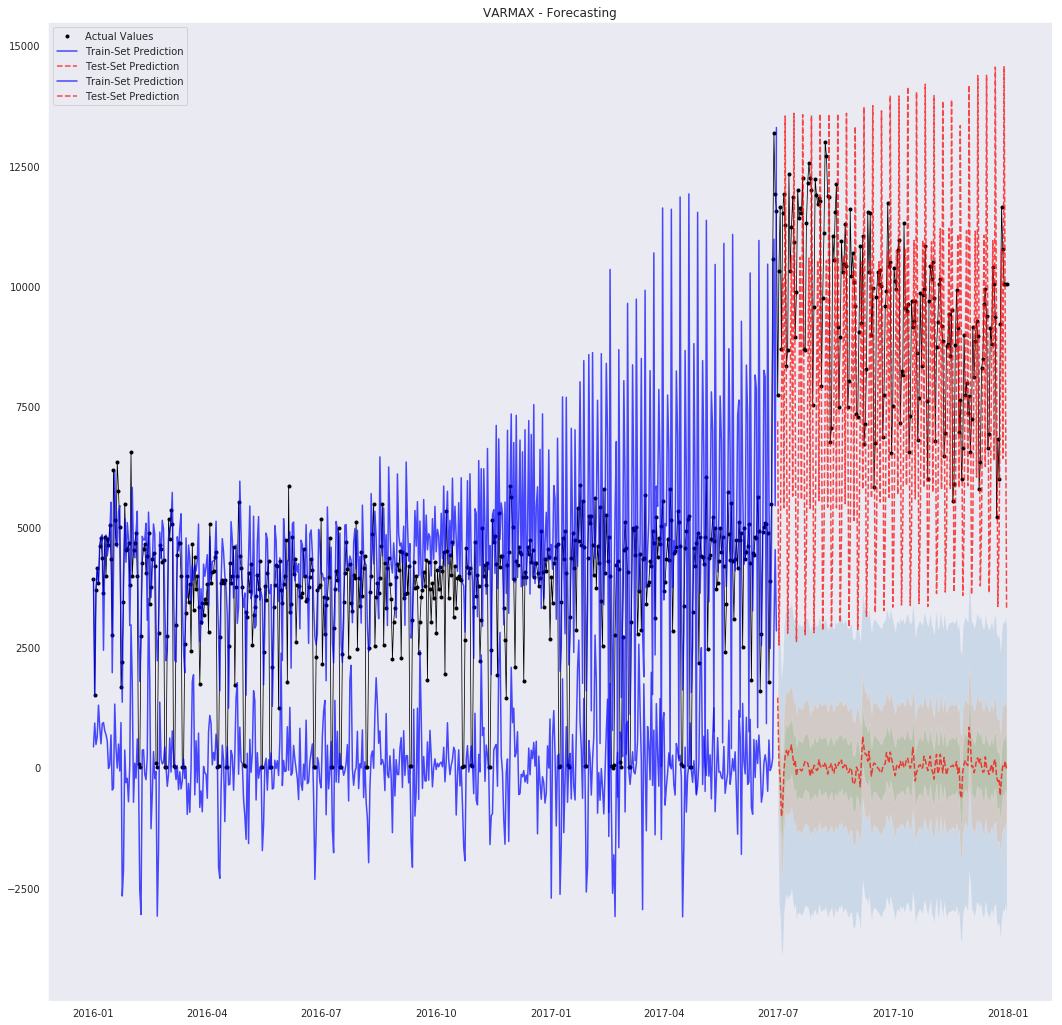

In [939]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delex')

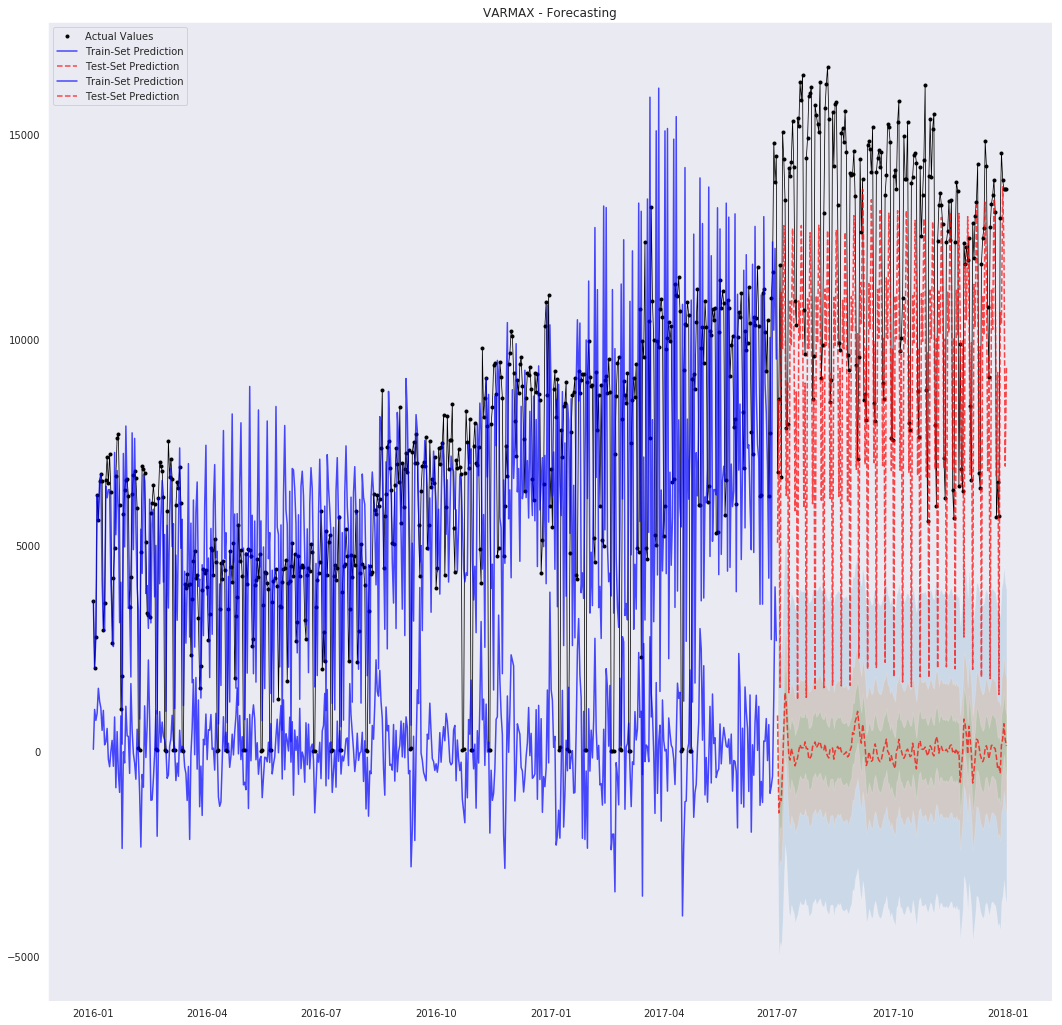

In [940]:
make_prediction_plot(df_merged, train_y, test_y, predict, 'delent')